In [69]:
# MODEL COMPARISON!

In [70]:
# MODEL COMPARISON

env = 'colab'  # 'colab' only
assert env == 'colab'

git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/model_comparison/'
final_models_path = '/content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/SuccessfulTrialsNoCLAHE/'

In [71]:
names = [
         # Names of final, fully-fit models for comparison
         'CNN',
         'Dropout',
         'AlexNet',
         'VGG16',
         'VGG19'
]

# Packages & functions

In [72]:
# %%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
            'DataProperties.py',
            'Utils.py',
            'ModelUtils.py'
    ]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [74]:
from os.path import isdir
from os.path import isfile
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import importlib


In [75]:
import Utils
import DataProperties
import ModelUtils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        Utils
    ]
)

from Utils import *

# Download necessary data

In [76]:
assert isdir(final_models_path) == True
available_models = listdir(final_models_path)

for name in names:
    assert name in available_models

In [77]:
def load_train_times(model_names, base_dir):
    res = {name: None for name in model_names}
    
    for name in model_names:
        model_dir = f'{base_dir}{name}/'
        assert(isdir(model_dir))

        file_path = f'{model_dir}training_time.csv'
        res[name] = pd.read_csv(file_path)

    return res

train_time_dict = load_train_times(names, base_dir = final_models_path)

In [78]:
def load_test_metrics(model_names, base_dir):
    
    res = {name: None for name in model_names}
    for name in model_names:
        model_dir = f'{base_dir}{name}/'
        assert isdir(model_dir)

        file_path = f'{model_dir}test_metrics_res.csv'
        res[name] = pd.read_csv(file_path)
    return res

test_metrics_dict = load_test_metrics(
    model_names = names,
    base_dir = final_models_path
)

In [79]:
def load_histories(model_names, base_dir):
    res = {name: None for name in model_names}

    for name in names:
        history_dir = f'{base_dir}{name}/Histories/'
        assert isdir(history_dir) == True

        file_path = f'{history_dir}{name}_history.csv'
        assert isfile(file_path)

        res[name] = pd.read_csv(file_path)
    
    return res


histories_dict = load_histories(
    model_names = names,
    base_dir = final_models_path
)

# Summary of learning curves

In [80]:
def plot_learning_curves(
    names, 
    hist_dict, 
    metrics_name, 
    figsize = (10, 10),
    title = 'PUT TITLE',
    ylabel = 'PUT LABEL',
    plot_validation = False
):

    fig, ax = plt.subplots(figsize = figsize)

    plt_params_dict = dict(
        marker = 'o',
        markersize = 7,
        markerfacecolor = 'white'
    )

    fontsize = 20  # Axis writing
    ticksize = 20  # Ticks writing
    legendsize = 19

    for name in names:
        data = hist_dict[name][metrics_name]
        ax.plot(data, **plt_params_dict)
        
        if plot_validation:
            val_data = hist_dict[name][f'val_{metrics_name}']
            ax.plot(val_data, **plt_params_dict)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)
    ax.set_xlabel('Epoch', fontsize = fontsize)
    ax.set_ylabel(ylabel, fontsize = fontsize)
    ax.grid()

    
    legend_names = []
    if plot_validation:
        pairs = [[name, f'{name} (val)'] for name in names]
        for p in pairs:
            legend_names.append(p[0])
            legend_names.append(p[1])
            
    else:
        legend_names = names
    ax.legend(legend_names, fontsize = legendsize)

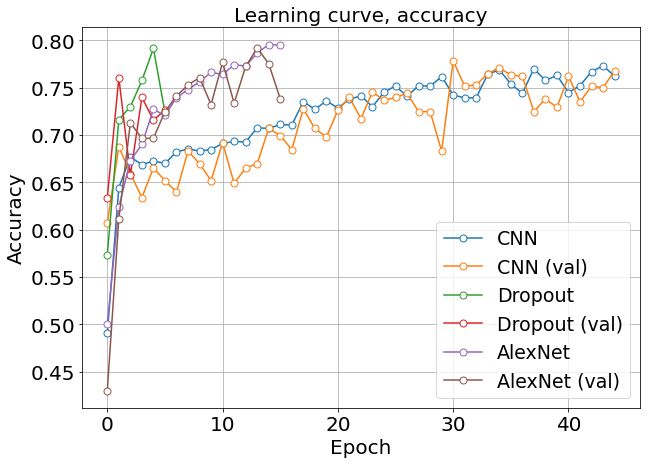

In [81]:
plot_learning_curves(
    names[:3],
    histories_dict,
    figsize = (10, 7),
    metrics_name = 'acc',
    title = 'Learning curve, accuracy',
    ylabel = 'Accuracy',
    plot_validation = True
)

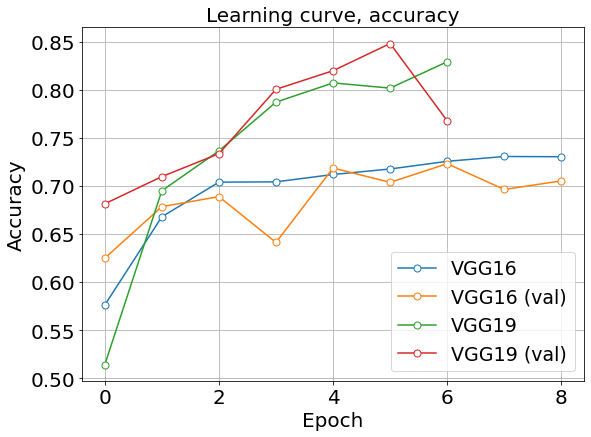

In [82]:
plot_learning_curves(
    names[3:],
    histories_dict,
    figsize = (9, 6.5),
    metrics_name = 'acc',
    title = 'Learning curve, accuracy',
    ylabel = 'Accuracy',
    plot_validation = True
)

# Gather summarized metrics

In [83]:
def summarize_metrics(model_names, metrics_dict):
    available_names = list(metrics_dict.keys())
    
    for n in model_names:
        assert n in available_names

    series = [metrics_dict[name] for name in model_names]
    res = pd.concat(series, ignore_index = True)
    res = res.set_index('Unnamed: 0')
    return res

df_summary = summarize_metrics(
    model_names = names,
    metrics_dict = test_metrics_dict
)

df_summary.head()

,F1,data_eval_time_sec,data_size,precision,recall,test_accuracy,test_loss^(-1),tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
Unnamed: 0,,,,,,,,,,,
CNN,0.825702,323.020724,681.0,0.839124,0.829662,0.829662,0.771877,10788643.0,1.0,1.0,1.0
Dropout,0.775021,142.668023,681.0,0.820184,0.775330,0.775330,0.539591,12001059.0,1.0,1.0,1.0
AlexNet,0.877747,323.070328,681.0,0.881692,0.876652,0.876652,0.393449,62381347.0,1.0,1.0,1.0
VGG16,0.829111,442.816964,681.0,0.852415,0.831131,0.831131,0.473869,134272835.0,1.0,1.0,1.0
VGG19,0.870579,502.980399,681.0,0.877432,0.870778,0.870778,0.317239,139582531.0,1.0,1.0,1.0


# Performance metrics

In [89]:
performance_metrics = [
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall'
]

In [90]:
complexity_metrics = [
                   'tr_params',
                   'data_eval_time_sec',
                   'test_loss^(-1)'
]

In [123]:
def plot_metrics(df, metric_names, model_names, figsize = (15, 15), title = ''):

    fontsize = 20
    ticksize = 20
    legendsize = 16
    tick_freq = 0.1
    
    ax = df.loc[model_names, metric_names].plot.bar(
        rot = 0,
        width = 0.9,
        figsize = figsize
    )

    y_ticks = np.arange(0, 1.01, tick_freq)
    ax.set_yticks(y_ticks)


    ax.set_xlabel('', fontsize = fontsize)
    ax.set_ylabel('Metrics', fontsize = fontsize)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)

    ax.legend(bbox_to_anchor = (1.0, 1.01), fontsize = legendsize)
    ax.grid()

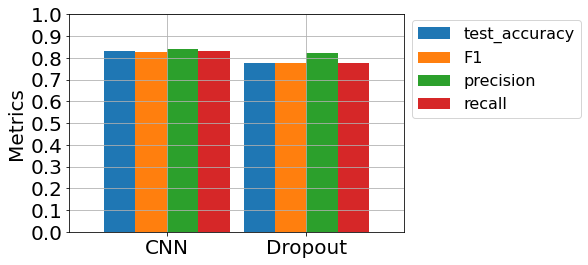

In [124]:
plot_metrics(
    df_summary, 
    performance_metrics,
    ['CNN', 'Dropout'],
    figsize = (6, 4),
    title = ''
)

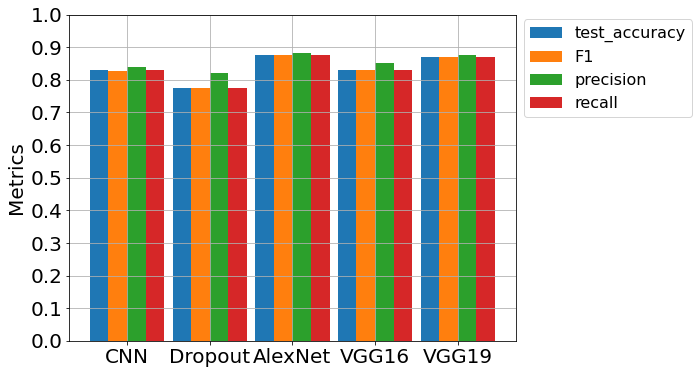

In [128]:
plot_metrics(
    df_summary, 
    performance_metrics,
    names,
    figsize = (8, 6),
    title = ''
)

# Complexity metrics

In [129]:
def plot_complexity_metrics(
    df,
    metric_names,
    model_names,
    figsize = (20, 20),
    title = ''
):

    # The complexity metrics are of different ranges 
    # and nature (time, number of parameters). We do max-normalization

    fontsize = 20
    ticksize = 20
    legendsize = 16
    tick_freq = 0.1

    df_subset = df.loc[model_names, metric_names]

    for m in metric_names:
        df_subset[m] = df_subset[m] / df_subset[m].max()  # Normalization
    
    ax = df_subset.plot.bar(
        rot = 0,
        width = 0.9,
        figsize = figsize
    )

    y_ticks = np.arange(0, 1.01, tick_freq)
    ax.set_yticks(y_ticks)


    ax.set_xlabel('', fontsize = fontsize)
    ax.set_ylabel('Metrics', fontsize = fontsize)

    ax.tick_params(axis = 'both', labelsize = ticksize)
    ax.set_title(title, fontsize = fontsize)

    ax.legend(bbox_to_anchor = (1.0, 1.0), fontsize = legendsize)
    ax.grid()

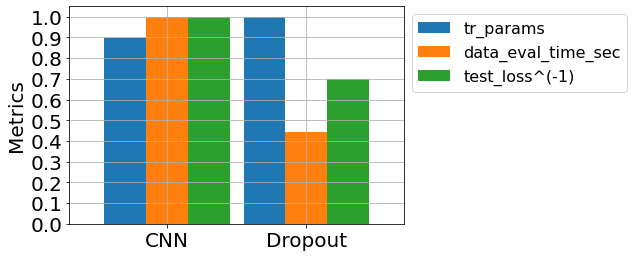

In [130]:
plot_complexity_metrics(
    df_summary, 
    complexity_metrics,
    ['CNN', 'Dropout'],
    figsize = (6, 4)
)

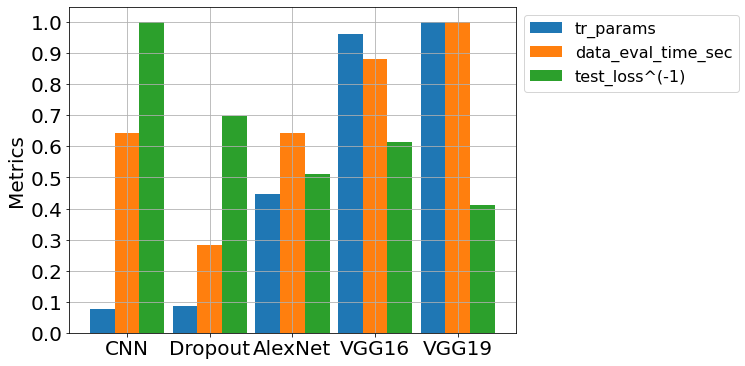

In [131]:
plot_complexity_metrics(
    df_summary, 
    complexity_metrics,
    names,
    figsize = (8, 6)
)

# Domain - related metrics

# Models evaluation

## Reload history and training time

In [ ]:
training_time_path = f'{DataProps.core_path}{date_}/trial-{n_trial}/'
evaluation_path = f'{DataProps.core_path}{date_}/trial-{n_trial}/'

In [ ]:
training_time_df = pd.read_csv(
    f'{evaluation_path}training_time.csv'
)
training_time_df = training_time_df.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

In [ ]:
training_time_df.head()

,Unnamed: 0,VGG16
0,0,128.598126
1,1,256.035699
2,2,383.709220
3,3,511.234345
4,4,639.911254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


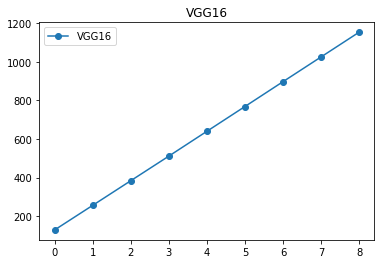

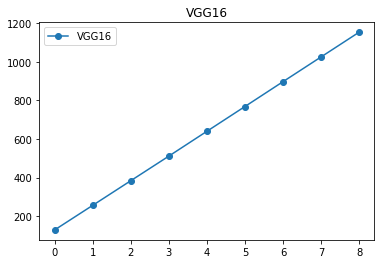

In [ ]:
def visualize_train_time(df, names):
    _, ax = plt.subplots()
    for name in names:
        values = df[name].values
        values = values[values != '']  # yes, crappy code, i dont have a lot of time yet
        ax.plot(*values, marker = 'o')
    ax.set_title(name)
    ax.legend(names)


visualize_train_time(training_time_df, names)

# For separate graphs
for name in names:
   visualize_train_time(training_time_df, [name])

## Full train time, seconds per epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


128.5981260000001 <class 'numpy.float64'>


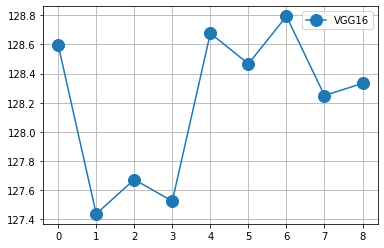

In [ ]:
def visualize_time_per_epoch(df, names):
    fig, ax = plt.subplots()
    for name in names:
        time_series = df[name].values
        time_series = time_series[time_series != '']
        time_series = time_series[0]
        deltas = [time_series[i] - time_series[i-1] for i in range(1, len(time_series))]
        deltas.insert(0, time_series[0])
        print(deltas[0], type(deltas[0]))
        ax.plot(deltas, marker = 'o', markersize = 12)
    ax.grid()
    ax.legend(names)


visualize_time_per_epoch(training_time_df, names)

## Test flow performance

In [ ]:
if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        metrics_dict = collect_metrics(models, test_flow, test_steps)
else:
    metrics_dict = collect_metrics(models, test_flow, test_steps)

681/681 [==============================] - 430s 630ms/step - loss: 0.4739 - acc: 0.8311


In [ ]:
def normalize_col(df, colnames):
    for c in colnames:
        df[c + '_norm'] = df[c] / np.max(df[c])

test_metrics_df = pd.DataFrame(metrics_dict).transpose()

normalize_col(
    test_metrics_df,
    [
        'data_eval_time_sec',
        'tr_params',
        'test_loss^(-1)'
    ]
)

In [ ]:
test_metrics_df.head()

,F1,data_eval_time_sec,data_size,precision,recall,test_accuracy,test_loss^(-1),tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
VGG16,0.829111,442.816964,681.0,0.852415,0.831131,0.831131,0.473869,134272835.0,1.0,1.0,1.0


In [ ]:
if saving_metrics_report:
    print(f'Saving metrics to {evaluation_path}')
    test_metrics_df.to_csv(evaluation_path + 'test_metrics_res.csv')

Saving metrics to /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/2022-01-31/trial-1/


<Figure size 1080x1080 with 0 Axes>

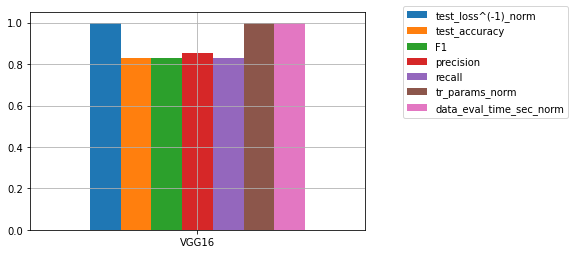

In [ ]:
metrics_to_show = [
                   'test_loss^(-1)_norm',
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall',
                   
                   'tr_params_norm',
                   'data_eval_time_sec_norm'
]

plt.figure(figsize = (15, 15))
ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
    rot = 0,
    width = 0.9
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

## Confusion matrices

In [ ]:
for m_name, model in models.items():
    test_flow.reset()
    plot_confusion_matrix(
        Y_true = test_flow.classes, 
        Y_pred = model.flow_predict(
            test_flow,
            test_steps
        ),
        class_indices = test_flow.class_indices
    )

## Learning curves

In [ ]:
histories_path = f'{evaluation_path}/Histories/'
histories_dfs = {}

In [ ]:
for name in names:
    file_path = f'{histories_path}{name}_history.csv'
    df = pd.read_csv(file_path)
    histories_dfs[name] = df

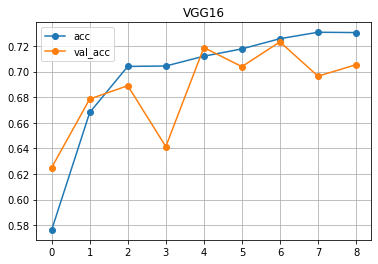

In [ ]:
def plot_learning_curves(histories_dict):
    for name, df in histories_dict.items():
        _, ax = plt.subplots()

        acc = df['acc']
        val_acc = df['val_acc']
        ax.plot(acc, marker = 'o')
        ax.plot(val_acc, marker = 'o')
        ax.set_title(name)
        ax.legend(['acc', 'val_acc'])
        plt.grid()

plot_learning_curves(histories_dfs)

## Layers interpretation

In [ ]:
img_n = 7

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 0, 
        n_kernel = 0, 
        
        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],  # 10th image 
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 4,
        n_kernel = 0,

        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )